# Load Data

In [94]:
# show all output from a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import packages
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import *
from pyspark.sql.types import DateType

# set spark contexts
sc = spark.sparkContext
sql_sc = SQLContext(sc)
spark = SparkSession.builder.getOrCreate()

import pandas as pd
import string
import re
import nltk
# !pip install --pre langid
import langid
import matplotlib.pyplot as plt

In [2]:
# load data
df = spark.read.format('csv').option('escape',"\"").option('header',True).load('../Project/news.csv')
# newsdfpd = pd.read_csv('news.csv') 
# newsdf = sql_sc.createDataFrame(newsdfpd) # method 2 - convert pandas df to spark df


# delete [''] in author column
df = df.withColumn('authors', regexp_replace('authors', "(^\\[')", ''))
df = df.withColumn('authors', regexp_replace('authors', "('\\])", ''))
# change publish_date from string to date
df = df.withColumn('publish_date', df['publish_date'].cast(DateType()))

# change col names
newcolnamelist = list(map(lambda x:x.replace('_c0','index'), df.columns))
df = df.toDF(*newcolnamelist)

# show columns info
df.columns
df.printSchema()

# check if there is na for column descriptiona and text
df.count()
df.dropna(subset=['description', 'text']).count()

# show top two rows of df
df.show(2)

['index', 'authors', 'title', 'publish_date', 'description', 'text', 'url']

root
 |-- index: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publish_date: date (nullable = true)
 |-- description: string (nullable = true)
 |-- text: string (nullable = true)
 |-- url: string (nullable = true)



3566

3566

+-----+--------+--------------------+------------+--------------------+--------------------+--------------------+
|index| authors|               title|publish_date|         description|                text|                 url|
+-----+--------+--------------------+------------+--------------------+--------------------+--------------------+
|    0|Cbc News|Coronavirus a 'wa...|  2020-03-27|Canadian pharmaci...|Canadian pharmaci...|https://www.cbc.c...|
|    1|Cbc News|Yukon gov't names...|  2020-03-27|The Yukon governm...|The Yukon governm...|https://www.cbc.c...|
+-----+--------+--------------------+------------+--------------------+--------------------+--------------------+
only showing top 2 rows



# Simple Word Count

In [75]:
# convert the text column to rdd format
text_rdd = df.select('text').rdd.map(list)

# split texts into words
splitted_word_rdd = text_rdd.flatMap(lambda line: line[0].split(' '))

# count word
print('Total word count:', text_word_rdd.count())

# mark each word to 1
word_map_rdd = splitted_word_rdd.map(lambda word: (word, 1))

# count words
word_count_rdd = word_map_rdd.reduceByKey(lambda a, b: a + b)

# count unique words
print('Unique word count:', word_count_rdd.count())


# show result of word count
word_count_list = word_count_rdd.collect()
print(word_count_list[0:20])

Total word count: 2526917
Unique word count: 116920
[('are', 20485), ('limiting', 262), ('try', 580), ('prevent', 927), ('recognizing', 19), ('active', 93), ('ingredients', 38), ('India', 68), ('China', 2029), ('medical', 2472), ('have', 16521), ('of', 60052), ('COVID-19.', 1669), ('regulatory', 30), ('complying', 24), ('Pharmacists', 18), ('call', 1255), ('amount', 225), ('medications', 64), ('patients', 1390)]


# NLP

## Text Preprocessing

In [75]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kcapple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to /Users/kcapple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kcapple/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

[nltk_data] Downloading package wordnet to /Users/kcapple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kcapple/nltk_data...


True

In [64]:
# functions for text preprocessing

def sent_tokenize_funct(x):
    return nltk.sent_tokenize(x)

def word_tokenize_funct(x):
    splitted = [word for line in x for word in line.split()]
    return splitted

def remove_stopwords_funct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))
    filteredSentence = [w for w in x if not w in stop_words]
    return filteredSentence

def remove_punct_funct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered

def lemma_funct(x):
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    finalLem = [lemmatizer.lemmatize(s) for s in x]
    return finalLem

def join_tokens_funct(x):
    joinedTokens_list = []
    x = " ".join(x)
    return x

def extract_phrase_funct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))
    def leaves(tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()
    
    def get_terms(tree):
        for leaf in leaves(tree):
            term = [w for w,t in leaf if not w in stop_words]
            yield term
    sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
    grammar = r"""
    NBAR:
        {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
        {<NBAR>}
        {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
    """
    chunker = nltk.RegexpParser(grammar)
    tokens = nltk.regexp_tokenize(x,sentence_re)
    postoks = nltk.tag.pos_tag(tokens) #Part of speech tagging 
    tree = chunker.parse(postoks) #chunking
    terms = get_terms(tree)
    temp_phrases = []
    for term in terms:
        if len(term):
            temp_phrases.append(' '.join(term))
    
    finalPhrase = [w for w in temp_phrases if w] #remove empty lists
    return finalPhrase

In [77]:
# create text rdd
text_rdd = df.select('text').rdd.flatMap(lambda x: x)
text_rdd = text_rdd.map(lambda s: s.replace("\xa0"," "))
# convert text ot lower case
lowercase_text_rdd = text_rdd.map(lambda x: x.lower())
# tokenzie sentences
sent_tokenize_rdd = lowercase_text_rdd.map(sent_tokenize_funct)
# tokenzie words
word_tokenize_rdd = sent_tokenize_rdd.map(word_tokenize_funct)
# remove stopwrods
rmv_stopword_rdd = word_tokenize_rdd.map(remove_stopwords_funct)
# remove punctuations
rmv_punct_rdd = rmv_stopword_rdd.map(remove_punct_funct)
# lemmatization
lemma_word_rdd = rmv_punct_rdd.map(lemma_funct)
# join tokens
joined_tokens_rdd = lemma_word_rdd.map(join_tokens_funct)
# extracct phrases
phrase_rdd = joined_tokens_rdd.map(extract_phrase_funct)

## Word Sentiment

In [76]:
def sentiment_word_funct(x):
    from nltk.sentiment.vader import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer() 
    senti_list_temp = []
    for i in x:
        y = ''.join(i) 
        vs = analyzer.polarity_scores(y)
        senti_list_temp.append((y, vs))
        senti_list_temp = [w for w in senti_list_temp if w]
    sentiment_list  = []
    for j in senti_list_temp:
        first = j[0]
        second = j[1]
    
        for (k,v) in second.items():
            if k == 'compound':
                if v < 0.0:
                    sentiment_list.append((first, "Negative"))
                elif v == 0.0:
                    sentiment_list.append((first, "Neutral"))
                else:
                    sentiment_list.append((first, "Positive"))
    return sentiment_list


# sentiment words and phrases
sentiment_rdd = phrase_rdd.map(sentiment_word_funct)

In [89]:
sentiment_rdd.take(20)

[[('canadian pharmacy', 'Neutral'),
  ('much medication', 'Neutral'),
  ('prevent shortage', 'Negative'),
  ('active ingredient drug', 'Positive'),
  ('india china medical supply chain', 'Neutral'),
  ('spread covid19 provincial regulatory college', 'Neutral'),
  ('canadian pharmacist association call limit amount medication', 'Neutral'),
  ('supply goal stop people', 'Negative'),
  ('prescription', 'Neutral'),
  ('drug', 'Neutral'),
  ('short supply chain', 'Neutral'),
  ('tadrous pharmacist researcher toronto monitor pharmaceutical supply',
   'Neutral'),
  ('canadian start', 'Neutral'),
  ('drug', 'Neutral'),
  ('unfolding u region virus spread', 'Neutral'),
  ('pharmacist', 'Neutral'),
  ('drug', 'Neutral'),
  ('inhaler people', 'Neutral'),
  ('misinformation', 'Negative'),
  ('potential treatment covid19', 'Neutral'),
  ('relationship people', 'Neutral'),
  ('actual supply medication', 'Neutral'),
  ('pharmacy', 'Neutral'),
  ('medication supply wholesaler get distributor source m

In [ ]:
# sentiment analysis

## Word Frequency

In [80]:
# add requency to each word or phase
freq_dist_RDD = phrase_rdd.flatMap(lambda x : nltk.FreqDist(x).most_common()). \
    map(lambda x: x).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending = False)

In [81]:
freq_dist_RDD.take(20)

[('people', 5171),
 ('day', 2105),
 ('case', 1903),
 ('week', 1216),
 ('canada', 1052),
 ('country', 984),
 ('province', 973),
 ('home', 815),
 ('covid19', 786),
 ('virus', 761),
 ('march', 747),
 ('coronavirus', 648),
 ('time', 630),
 ('cent', 624),
 ('year', 617),
 ('government', 598),
 ('china', 541),
 ('community', 529),
 ('month', 495),
 ('death', 478)]

In [92]:
# converting RDD to spark dataframe
df_freq_dist = freq_dist_RDD.toDF(['keywords','frequency'])
# create data table
df_freq_dist.createOrReplaceTempView("wordfreq") 
# select the top 20 keywords and convert spark dataframes to pandas dataframes
top20pddf = spark.sql("SELECT keywords, frequency from wordfreq limit 20").toPandas()
top20pddf.head()

,keywords,frequency
0,people,5171
1,day,2105
2,case,1903
3,week,1216
4,canada,1052


Text(0.5, 0, 'Frequency')

Text(0, 0.5, 'Keywords')

Text(0.5, 1.0, 'Top 20 Keywords Frequency')

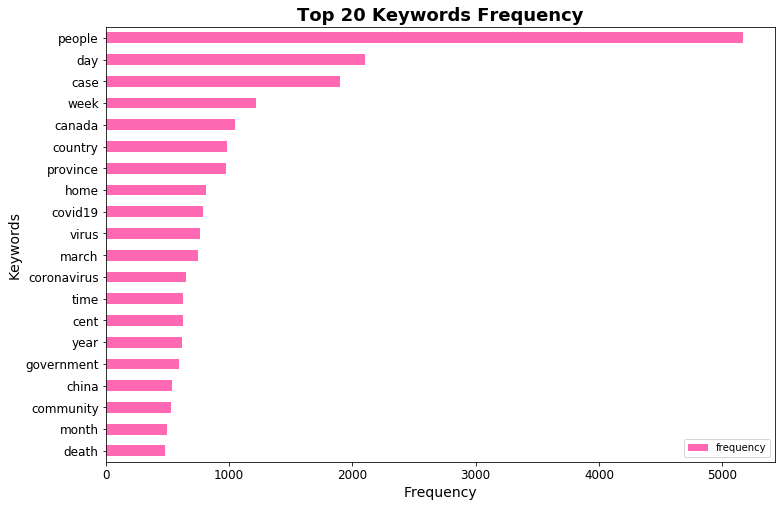

In [125]:
# plot top 20 keywords
ax = top20pddf.plot.barh(x='keywords', y='frequency',figsize=(12,8), fontsize=12, align='center',color='hotpink')
ax.invert_yaxis()
ax.set_xlabel('Frequency', fontsize=14)
ax.set_ylabel('Keywords', fontsize=14)
ax.set_title('Top 20 Keywords Frequency', fontsize=18, fontweight='bold')

## Word Cloud